<a href="https://colab.research.google.com/github/MaricelaMH/Simulacion-1/blob/main/Otras_aplicaciones_ej.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

E - J - E - R - C - I - C - I - O   --- 5.10

La demanda diaria y el tiempo de entrega de un cierto producto, siguen las siguientes distribuciones de probabilidad:

![texto alternativo](https://drive.google.com/uc?id=1N6Od4AThez6NpVqWDsv1cl5RuaXcxp6l)

La información con respecto a los costos relevantes es la siguiente:
$$\text{Costo de ordenar } = \$ 50 / orden $$
$$ \text{Costo de inventario = } \$26 /unidad/año $$
$$ \text{Costo de faltante = } \$25 /unidad $$

Si el inventario inicial es de 15 unidades, ¿Determine la cantidad óptima a ordenar $(q)$ y el nivel optimo de reorden $(R)$? (Asuma que se trabajan 260 dias en el año.)



In [61]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
from tabulate import tabulate

In [62]:
def demanda():  # Función para calcular la demanda diaria
    demanda_diaria = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    prob_demanda = [0.04, 0.06, 0.10, 0.20, 0.30, 0.18, 0.08, 0.03, 0.01]
    u = rnd.random()
    prob_acom = np.cumsum(prob_demanda)
    for i, prob in enumerate(prob_acom):
        if u <= prob:
            return demanda_diaria[i], u

In [63]:
def tiemp_entrega():  # Función para calcular el tiempo de entrega
    tiempo = [1, 2, 3, 4]
    prob_tiempo = [0.25, 0.50, 0.20, 0.05]
    v = rnd.random()
    prob_acom = np.cumsum(prob_tiempo)
    for i, prob in enumerate(prob_acom):
        if v <= prob:
            return tiempo[i]

In [64]:
def inventario(q, R):  # Función principal de inventario
    inv_inicial = 15  # Inventario inicial es 15 unidades
    inventario_i = [inv_inicial]
    inv_falt = 0
    carga_pend = False
    tie_entrega = 0
    cont = -1
    faltante = 0
    lista = []
    cont_ent = 0

    for dia in range(260):  # Consideramos un ciclo de 260 días
        dem, _ = demanda()  # Llamar a la función de demanda
        inv_final = inv_inicial - dem  # Calcular inventario final

        if inv_final <= R and not carga_pend:
            tie_entrega = tiemp_entrega()
            carga_pend = True
            cont_ent += 1

        if carga_pend:
            cont += 1

        if inv_final < 0:
            faltante = abs(inv_final)
            lista.append([dia+1, inv_inicial, dem, "-", faltante, tie_entrega])
            inv_falt += faltante
        else:
            lista.append([dia+1, inv_inicial, dem, inv_final, faltante, tie_entrega])

        inv_inicial = inv_final

        if cont == tie_entrega:
            cont = -1
            inv_inicial += q
            carga_pend = False
            tie_entrega = 0

        faltante = 0
        inventario_i.append(inv_inicial)

    suma_inv_prom = sum(inv_inicial for dia, inv_inicial, dem, inv_final, faltante, tie_entrega in lista if inv_final != "-")
    costo_total = cont_ent * 50 + suma_inv_prom * 26/260 + inv_falt * 25

    return costo_total, lista, inventario_i, cont_ent, suma_inv_prom, inv_falt


In [65]:
# Función objetivo para Hooke-Jeeves
def funcion_objetivo(parametros):
    q, R = map(int, parametros)
    costo_total, _, _, _, _, _ = inventario(q, R)
    return costo_total

In [66]:
# Método de Hooke-Jeeves
def hooke_jeeves(func, x0, delta, gamma, epsilon):
    x = np.array(x0, dtype=float)
    delta = np.array(delta, dtype=float)
    while np.any(delta > epsilon):
        mejorada = False
        for i in range(len(x)):
            for direc in [-1, 1]:
                x_nev = x.copy()
                x_nev[i] += direc * delta[i]
                if func(x_nev) < func(x):
                    x = x_nev
                    mejorada = True
                    break
            if mejorada:
                break
        if not mejorada:
            delta *= gamma
    return x

In [70]:
# Parámetros iniciales para Hooke-Jeeves
x0 = [50, 20]  # Valores iniciales de q y R
delta = [10.0, 10.0]  # Longitud de paso inicial
gamma = 0.5  # Factor de reducción
epsilon = 0.01  # Criterio de parada
# Ejecutar Hooke-Jeeves
q_opt, R_opt = hooke_jeeves(funcion_objetivo, x0, delta, gamma, epsilon)

In [71]:
# Comparar valores iniciales y óptimos
costo_inicial, lista_inicial, inventario_i_inicial, cont_ent_inicial, suma_inv_prom_inicial, inv_falt_inicial = inventario(*x0)
costo_optimo, lista_optima, inventario_i_optima, cont_ent_optima, suma_inv_prom_optima, inv_falt_optima = inventario(q_opt, R_opt)

# Imprimir comparación
print(f'Valores iniciales: q = {x0[0]}, R = {x0[1]}')
print(f'Costo total inicial: {costo_inicial}')
print(f'Valores óptimos: q = {q_opt}, R = {R_opt}')
print(f'Costo total óptimo: {costo_optimo}')


Valores iniciales: q = 50, R = 20
Costo total inicial: 1943.6
Valores óptimos: q = 61.09375, R = 14.921875
Costo total óptimo: 1860.4125


In [72]:
# Imprimir tablas
headers = ['Día', 'Inventario inicial', 'Demanda', 'Inventario final', 'Faltante', 'Entrega']

In [73]:
print("Resultados con valores iniciales:")
print(tabulate(lista_inicial, headers=headers, tablefmt="fancy_grid", showindex=False))


Resultados con valores iniciales:
╒═══════╤══════════════════════╤═══════════╤════════════════════╤════════════╤═══════════╕
│   Día │   Inventario inicial │   Demanda │   Inventario final │   Faltante │   Entrega │
╞═══════╪══════════════════════╪═══════════╪════════════════════╪════════════╪═══════════╡
│     1 │                   15 │         0 │                 15 │          0 │         2 │
├───────┼──────────────────────┼───────────┼────────────────────┼────────────┼───────────┤
│     2 │                   15 │         0 │                 15 │          0 │         2 │
├───────┼──────────────────────┼───────────┼────────────────────┼────────────┼───────────┤
│     3 │                   15 │         2 │                 13 │          0 │         2 │
├───────┼──────────────────────┼───────────┼────────────────────┼────────────┼───────────┤
│     4 │                   63 │         5 │                 58 │          0 │         0 │
├───────┼──────────────────────┼───────────┼────────────

In [74]:
print("Resultados con valores óptimos:")
print(tabulate(lista_optima, headers=headers, tablefmt="fancy_grid", showindex=False))

Resultados con valores óptimos:
╒═══════╤══════════════════════╤═══════════╤════════════════════╤════════════╤═══════════╕
│   Día │   Inventario inicial │   Demanda │ Inventario final   │   Faltante │   Entrega │
╞═══════╪══════════════════════╪═══════════╪════════════════════╪════════════╪═══════════╡
│     1 │             15       │         2 │ 13                 │        0   │         2 │
├───────┼──────────────────────┼───────────┼────────────────────┼────────────┼───────────┤
│     2 │             13       │         4 │ 9                  │        0   │         2 │
├───────┼──────────────────────┼───────────┼────────────────────┼────────────┼───────────┤
│     3 │              9       │         5 │ 4                  │        0   │         2 │
├───────┼──────────────────────┼───────────┼────────────────────┼────────────┼───────────┤
│     4 │             65.0938  │         5 │ 60.09375           │        0   │         0 │
├───────┼──────────────────────┼───────────┼──────────────

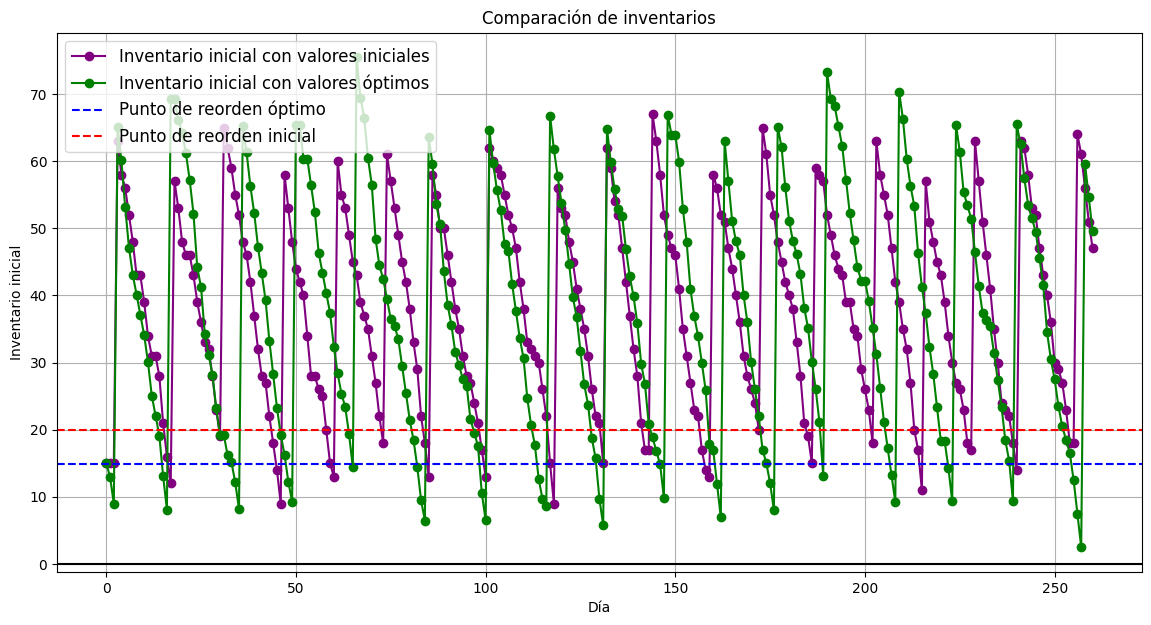

In [75]:
# Graficar comparación de inventarios
plt.figure(figsize=(14, 7))  # Aumentar el tamaño de la figura
plt.plot(inventario_i_inicial, color="purple", marker='o', label="Inventario inicial con valores iniciales")
plt.plot(inventario_i_optima, color="green", marker='o', label="Inventario inicial con valores óptimos")
plt.title('Comparación de inventarios')
plt.xlabel('Día')
plt.ylabel('Inventario inicial')
plt.axhline(R_opt, color="blue", linestyle='--', label='Punto de reorden óptimo')
plt.axhline(x0[1], color="red", linestyle='--', label='Punto de reorden inicial')
plt.axhline(0, color='black')
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

In [76]:
# Imprimir costos
costo_inicial_detalle = [cont_ent_inicial * 50, suma_inv_prom_inicial * 26/260, inv_falt_inicial * 25, costo_inicial]
costo_optimo_detalle = [cont_ent_optima * 50, suma_inv_prom_optima * 26/260, inv_falt_optima * 25, costo_optimo]

In [77]:
print("Costos con valores iniciales:")
print(tabulate([costo_inicial_detalle], headers=['Costo de ordenar', 'Costo de llevar el inventario', 'Costo de faltante', 'Costo total'], tablefmt="fancy_grid", showindex=False))


Costos con valores iniciales:
╒════════════════════╤═════════════════════════════════╤═════════════════════╤═══════════════╕
│   Costo de ordenar │   Costo de llevar el inventario │   Costo de faltante │   Costo total │
╞════════════════════╪═════════════════════════════════╪═════════════════════╪═══════════════╡
│                950 │                           993.6 │                   0 │        1943.6 │
╘════════════════════╧═════════════════════════════════╧═════════════════════╧═══════════════╛


In [78]:
print("Costos con valores óptimos:")
print(tabulate([costo_optimo_detalle], headers=['Costo de ordenar', 'Costo de llevar el inventario', 'Costo de faltante', 'Costo total'], tablefmt="fancy_grid", showindex=False))

Costos con valores óptimos:
╒════════════════════╤═════════════════════════════════╤═════════════════════╤═══════════════╕
│   Costo de ordenar │   Costo de llevar el inventario │   Costo de faltante │   Costo total │
╞════════════════════╪═════════════════════════════════╪═════════════════════╪═══════════════╡
│                850 │                         972.913 │                37.5 │       1860.41 │
╘════════════════════╧═════════════════════════════════╧═════════════════════╧═══════════════╛
